In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from models.model_config import *
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' : 'lmodern'
}
plt.rcParams.update(params)


/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_16883/3250400987.py:17: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [5]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [6]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [7]:
def get_best_student_ensamble(model, view, dataset, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

## Overview of the models and ensamble 

In [5]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [6]:
def get_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average metrics across all runs and all cv for any model 
    #EACH FOLD INDIVIDUAL

    data_mean = [] 
    data_var = [] 

    run_data = []   


    for run in runs:

        model_metrics = []
        
        for training_type in CV:
            
            model_cv_metrics = get_mean_CV_metric_student_model(
                dataset=dataset, 
                model=model, 
                analysis_type=analysis_type, 
                training_type=training_type, 
                view=view, 
                run=run, 
                student=-1, 
                dataset_split=dataset_split,
                model_args=model_args
                )
            model_metrics.append(model_cv_metrics)
        
        run_data.append(model_metrics)
        
    data_mean.append(np.mean(run_data, axis=0))   
    data_var.append(np.std(run_data, axis=0))        

    return data_mean, data_var

# REPRODUCIBILITY

In [8]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [9]:
def plot_bar_chart_reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None, save_fig=False):
    """
    USAGE:
    plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False
    )
    """
    plt.rcParams["figure.figsize"] = (20,8)

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    X = np.arange(len(views)+1)

    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i]+"_teacher", alpha=0.5)
        elif models[i] == "gcn_student_ensamble_3":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="best_student_ensemble", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i], alpha=0.5)
        
        sep += barWidth

    max_y_lim = 1 if np.amax(mean_all_runs) + np.max(mean_all_std) > 1 else np.amax(mean_all_runs) + np.max(mean_all_std)
    min_y_lim = 0 if np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01 < 0 else np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01
    plt.ylim(min_y_lim, max_y_lim)

    title = f"Reproducibility Score for Dataset:{dataset} across {len(runs)} different seeds for best student"

    plt.ylabel("Reproducibility Score")
    x_ticks = ["View {}".format(i) for i in views]+ ["Average"]

    plt.xticks([r + barWidth for r in range(len(mean_all_runs[0]))], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
            os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
        
        plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+title+".png", dpi=150,bbox_inches='tight')
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

# COMPARISON BETWEEN LSP AND LOGITS 

In [21]:
from models.model_config import *

analysis_type="model_assessment"
dataset = "gender_data"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_data_mean = []
all_model_data_std = []

for model_arg in models_args:
    
    model_data_mean = []
    model_data_std = []
    
    print(model_arg["model_name"])
    
    for view in [0,2,4,5]:
        
        rep = get_best_student_ensamble(
            model=model_arg["model_name"], 
            dataset=dataset,
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )[0]
        model_data_mean.append(rep[0])
        model_data_std.append(rep[1])
    
    all_model_data_mean.append(model_data_mean)
    all_model_data_std.append(model_data_std)

gcn_student_ensamble_2
gcn_student_ensamble_3
gcn_student_ensamble_4


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(all_model_data_mean)

df_transposed = df.T
# Calculate the mean along each column
mean_row = df_transposed.mean()

# Add the mean row to the transposed DataFrame
df_transposed = df_transposed.append(mean_row, ignore_index=True)
print(df_transposed.head())

          0         1         2         3         4         5         6  \
0  0.940556  0.968750  0.972222  0.966806  0.938472  0.969028  0.960000   
1  0.929722  0.932083  0.953056  0.967778  0.944444  0.931944  0.968889   
2  0.943889  0.957778  0.961111  0.975556  0.957917  0.966667  0.965000   
3  0.946111  0.948611  0.955278  0.959722  0.957778  0.956111  0.969028   
4  0.940069  0.951806  0.960417  0.967465  0.949653  0.955937  0.965729   

          7  
0  0.963889  
1  0.978333  
2  0.977222  
3  0.955417  
4  0.968715  


In [ ]:
df = pd.DataFrame(np.sqrt(all_model_data_std))

df_transposed_var = df.T
# Calculate the mean along each column
std_row = df_transposed.std()

# Add the mean row to the transposed DataFrame
df_std_transposed = df_transposed_var.append(std_row, ignore_index=True)
df_std_transposed

,0,1,2,3,4,5,6,7
0,0.022229,0.004270,0.017213,0.022209,0.016090,0.009624,0.019173,0.013322
1,0.018934,0.028467,0.022608,0.017222,0.019355,0.014055,0.007713,0.008498
2,0.026074,0.010323,0.011785,0.014530,0.017624,0.008607,0.011055,0.009027
3,0.019011,0.018405,0.011749,0.023741,0.014948,0.014262,0.013945,0.019399
4,0.006293,0.013435,0.007424,0.005611,0.008462,0.014681,0.003682,0.009553


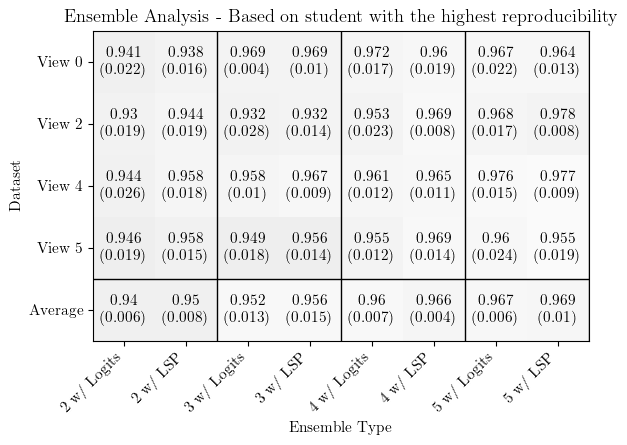

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_transposed.iloc[:, column_order]
df_std_ordered = df_std_transposed.iloc[:, column_order]

# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df.shape[0], 2):
    pair_max = max(df.iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')
if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Based on student with the highest reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()


In [ ]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_ensamble_2
[[0.9405555555555555, 0.000494135802469136, 0], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1]]
[[0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1], [0.8902777777777778, 0.0001358024691358015, 1], [0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1]]
[[0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1]]
[[0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1]]
gcn_student_ensamble_3
[[0.9687

In [ ]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(40, 5)

In [ ]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [ ]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [ ]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(40, 5)

In [ ]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(40, 5)

In [ ]:
df_acuracy = df_acuracy.loc['max rep'].T
df_var = df_var.loc['max rep'].T
df_var = np.sqrt(df_var)

In [ ]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
new_labels = ['2 w/ Logits', '3 w/ Logits', '4 w/ Logits','5 w/ Logits', '2 w/ LSP', '3 w/ LSP', '4 w/ LSP',  '5 w/ LSP']
# Rename the columns using the new labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
# Display the modified DataFrame
df_var

,2 w/ Logits,3 w/ Logits,4 w/ Logits,5 w/ Logits,2 w/ LSP,3 w/ LSP,4 w/ LSP,5 w/ LSP
0,0.005647,0.007414,0.010266,0.005254,0.003565,0.005010,0.009602,0.006157
1,0.002587,0.003368,0.003574,0.007661,0.003084,0.007322,0.004146,0.002374
2,0.006626,0.004166,0.002682,0.005347,0.005716,0.002912,0.002405,0.002883
3,0.004202,0.008354,0.004669,0.004186,0.006139,0.006898,0.003948,0.006130
4,0.005003,0.006194,0.006065,0.005754,0.004811,0.005805,0.005718,0.004728


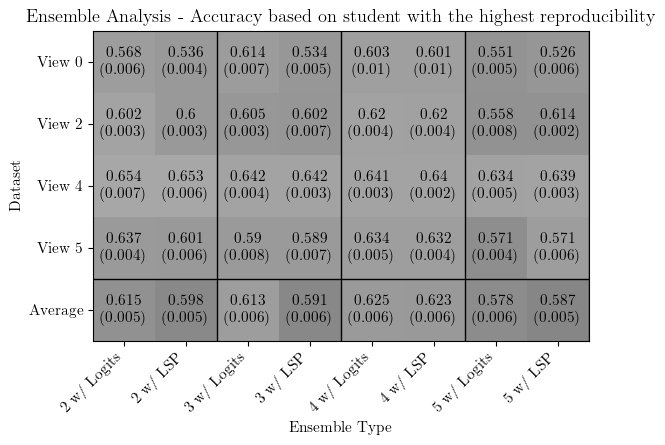

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_acuracy.iloc[:, column_order]
df_std_ordered = df_var.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df_ordered.T.shape[0], 2):
    print()
    pair_max = max(df_ordered.iloc[4].iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Accuracy based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Accuracy based on student with the highest reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()

## HOW TO PICK THE BEST STUDENT 

In [ ]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [ ]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)


gcn_student_lsp_ensamble_2
[[0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1]]
[[0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1], [0.8927777777777777, 0.0002483796296296277, 1], [0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1]]
[[0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1]]
[[0.9577777777777777, 0.0002234567901234572, 0], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1]]

In [ ]:
#Model, view, how to pick, [rep, std, index]
df_best_student = np.array(all_model_best_student)

In [ ]:
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df

,0,1,2,3,4
max rep,0.938472,0.944444,0.957917,0.957778,0.949653
max acc,0.938333,0.892778,0.957917,0.933056,0.930521
max f1,0.938472,0.892778,0.957917,0.933056,0.930556
weighted acc,0.938333,0.944444,0.957917,0.933056,0.943437
weighted f1,0.938472,0.892778,0.957917,0.933056,0.930556
max rep,0.969028,0.931944,0.966667,0.956111,0.955937
max acc,0.968333,0.896667,0.932222,0.921667,0.929722
max f1,0.968333,0.896667,0.966667,0.921667,0.938333
weighted acc,0.968333,0.931944,0.966667,0.921667,0.947153
weighted f1,0.968333,0.896667,0.966667,0.921667,0.938333


In [ ]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())


In [ ]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy

,0,1,2,3,4
max rep,0.535898,0.600378,0.653475,0.600888,0.597660
max acc,0.563971,0.636689,0.653475,0.633602,0.621934
max f1,0.535898,0.636689,0.653475,0.633602,0.614916
weighted acc,0.563971,0.600378,0.653475,0.633602,0.612857
weighted f1,0.535898,0.636689,0.653475,0.633602,0.614916
max rep,0.533604,0.601620,0.641890,0.588522,0.591409
max acc,0.611339,0.625489,0.653350,0.634708,0.631222
max f1,0.611339,0.625489,0.641890,0.634708,0.628357
weighted acc,0.611339,0.601620,0.641890,0.634708,0.622390
weighted f1,0.611339,0.625489,0.641890,0.634708,0.628357


In [ ]:
max_value = df_acuracy[:5][4].values.max()
max_indices_acc = np.where(df_acuracy[:5][4].values == max_value)

max_value = df[:5][4].values.max()
max_indices_rep = np.where(df[:5][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [ ]:
max_value = df_acuracy[5:10][4].values.max()
max_indices_acc = np.where(df_acuracy[5:10][4].values == max_value)

max_value = df[5:10][4].values.max()
max_indices_rep = np.where(df[5:10][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [ ]:
max_value = df_acuracy[10:15][4].values.max()
max_indices_acc = np.where(df_acuracy[10:15][4].values == max_value)

max_value = df[10:15][4].values.max()
max_indices_rep = np.where(df[10:15][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0, 2, 3, 4]),))

In [ ]:
ensamble_4_acc = df_acuracy[10:15]
ensamble_4_rep = df[10:15]
ensamble_4_acc

,0,1,2,3,4
max rep,0.601303,0.619532,0.640231,0.631901,0.623242
max acc,0.601303,0.623435,0.646875,0.631901,0.625879
max f1,0.601303,0.619532,0.640231,0.631901,0.623242
weighted acc,0.601303,0.619532,0.640231,0.631901,0.623242
weighted f1,0.601303,0.619532,0.640231,0.631901,0.623242


In [ ]:
ensamble_4_rep

,0,1,2,3,4
max rep,0.96,0.968889,0.965000,0.969028,0.965729
max acc,0.96,0.930694,0.914306,0.969028,0.943507
max f1,0.96,0.968889,0.965000,0.969028,0.965729
weighted acc,0.96,0.968889,0.965000,0.969028,0.965729
weighted f1,0.96,0.968889,0.965000,0.969028,0.965729


In [ ]:
max_value = df_acuracy[15:20][4].values.max()
max_indices_acc = np.where(df_acuracy[15:20][4].values == max_value)

max_value = df[15:20][4].values.max()
max_indices_rep = np.where(df[15:20][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

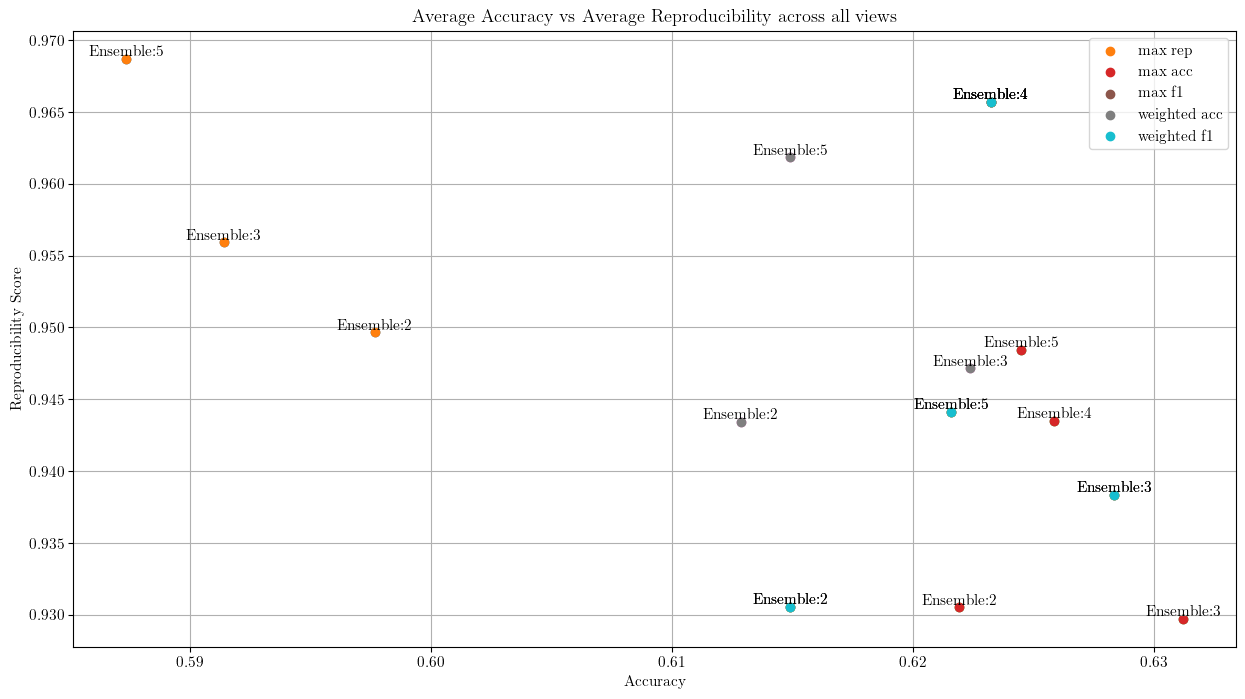

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (15,8)
all_x = []
all_y = []

for method in ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1']:
    # Assuming you have two DataFrames: df1 and df2
    # Let's say you want to plot column 'A' from df1 against column 'B' from df2
    labels = ["2", "3", "4", "5"]
    # Extract the columns of interest from the DataFrames
    x, y = df_acuracy.loc[method][4], df.loc[method][4]
    plt.scatter(x, y)

    # Create the scatter plot
    plt.scatter(x, y, label=method)

    # Add labels to each point
    for index, (i, j) in enumerate(zip(x, y)):
        plt.text(i, j, f'Ensemble:{labels[index]}', ha='center', va='bottom')
    # Customize the plot
    plt.xlabel('Accuracy')  # Add x-axis label
    plt.ylabel('Reproducibility Score')  # Add y-axis label
    plt.title(f'Average Accuracy vs Average Reproducibility across all views')  # Add title
    plt.grid()
    plt.legend()
    all_x.append(x)
    all_y.append(y)

if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Average Accuracy vs Average Reproducibility across all views'+".png", dpi=150,bbox_inches='tight')

plt.show()  # Show the plot

In [ ]:
x = sum([x.tolist() for x in all_x], [])
y = sum([y.tolist() for y in all_y], [])
correlation_coefficient = np.corrcoef(x, y)[0, 1]
correlation_coefficient

-0.32042291884733676

# COMPARISON WITH OTHER METHODS

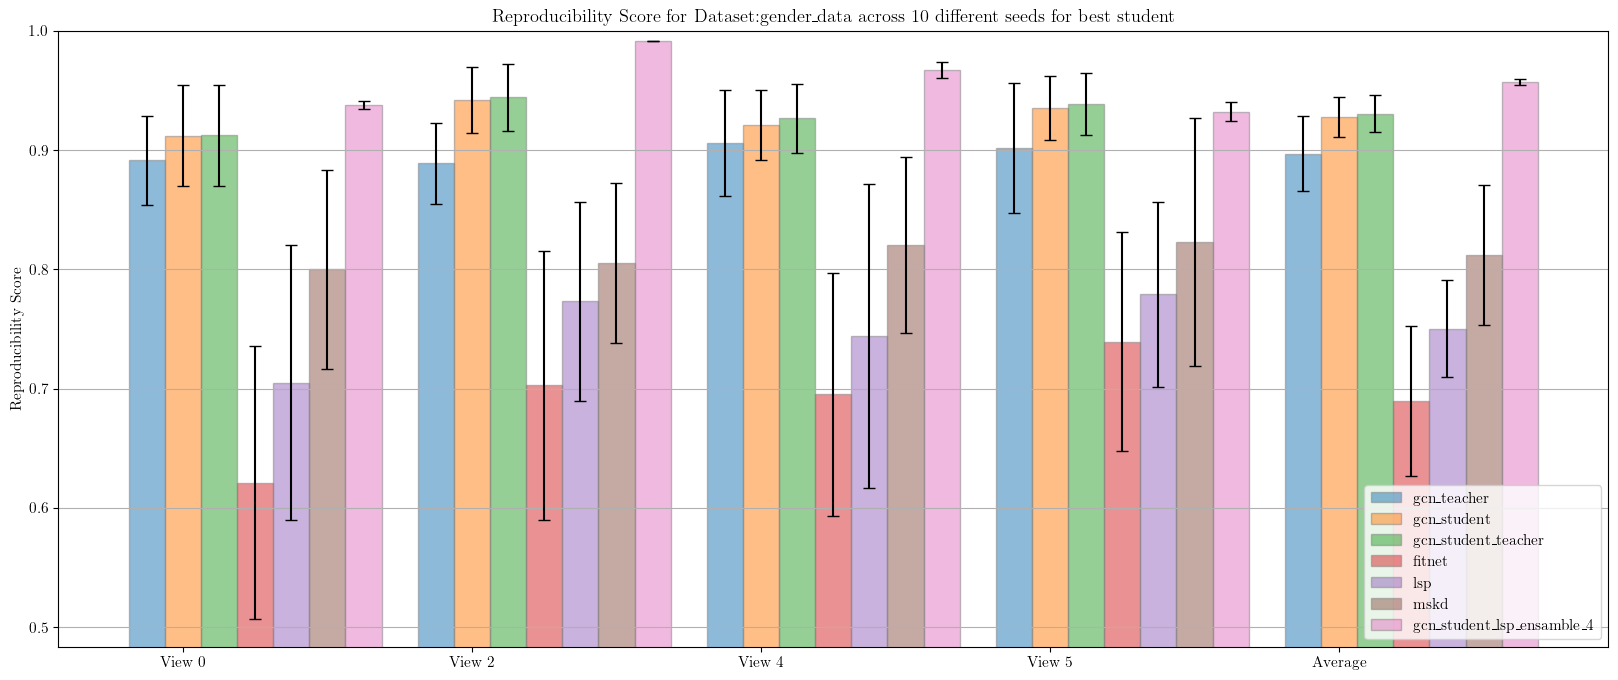

<Figure size 2000x800 with 0 Axes>

In [13]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_4"
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        gcn_fitnet_student_args, 
        gcn_lsp_student_args, 
        gcn_mskd_student_args,
        gcn_student_lsp_ensamble_4_args,
    ], 
    save_fig=False
)

In [14]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [15]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_4" 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        gcn_fitnet_student_args, 
        gcn_lsp_student_args, 
        gcn_mskd_student_args,
        gcn_student_lsp_ensamble_4_args
    ])

In [16]:
mean_all_runs, mean_all_std

(array([[0.89138889, 0.88875   , 0.90597222, 0.90166667, 0.89694444],
        [0.91208333, 0.94180556, 0.92097222, 0.93541667, 0.92756944],
        [0.9125    , 0.94430556, 0.92652778, 0.93875   , 0.93052083],
        [0.62111111, 0.70277778, 0.69527778, 0.73930556, 0.68961806],
        [0.70486111, 0.77305556, 0.74402778, 0.77916667, 0.75027778],
        [0.79986111, 0.80527778, 0.82055556, 0.82319444, 0.81222222],
        [0.93777778, 0.99166667, 0.96722222, 0.93222222, 0.95722222]]),
 array([[3.73753071e-02, 3.38812036e-02, 4.46827379e-02, 5.45633622e-02,
         3.13892730e-02],
        [4.21135755e-02, 2.78086634e-02, 2.94526325e-02, 2.66670284e-02,
         1.65163943e-02],
        [4.24373176e-02, 2.80572744e-02, 2.90304358e-02, 2.61940910e-02,
         1.52576019e-02],
        [1.14570791e-01, 1.12559998e-01, 1.01962230e-01, 9.16857093e-02,
         6.28246679e-02],
        [1.15249746e-01, 8.32944354e-02, 1.27487669e-01, 7.74148277e-02,
         4.07499858e-02],
        [8.34

In [17]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

In [18]:
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    #"gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4" 
]
reproducibility_frame.columns = models

"""
reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100
"""

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

In [19]:
reproducibility_frame

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_lsp_ensamble_4,delta teacher,delta student
0,0.891389,0.912083,0.912500,0.621111,0.704861,0.799861,0.937778,5.204113,2.817116
1,0.888750,0.941806,0.944306,0.702778,0.773056,0.805278,0.991667,11.579934,5.294204
2,0.905972,0.920972,0.926528,0.695278,0.744028,0.820556,0.967222,6.760693,5.021867
3,0.901667,0.935417,0.938750,0.739306,0.779167,0.823194,0.932222,3.388786,-0.341500
4,0.896944,0.927569,0.930521,0.689618,0.750278,0.812222,0.957222,6.720347,3.196826


In [20]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gcn_student_lsp_ensamble_4_args]

best_student = [2,1,2,1]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gcn_args,
                                                                                                                gcn_student_args,
                                                                                                                gcn_student_args, 
                                                                                                                gcn_fitnet_student_args, 
                                                                                                                gcn_lsp_student_args, 
                                                                                                                gcn_mskd_student_args
                                                                                                            ]
                                                                                                        )
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]
        """
        mean_df = np.array(model_mean[1])[:,i]
        mean_df = mean_df[np.newaxis, :]
    
        std_df = np.array(model_std[1])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[final_mean_df, mean_df]
        final_var_df = np.r_[final_var_df, std_df]        
        """


    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

NameError: name 'get_student_model_metric' is not defined

In [ ]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [ ]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6
0,0.610109,0.577844,0.581616,0.607256,0.612096,0.621827,0.601303
1,0.661582,0.637472,0.639818,0.642089,0.655798,0.657213,0.619532
2,0.669069,0.632487,0.637550,0.651959,0.664259,0.665079,0.640231
3,0.654419,0.636227,0.637657,0.644463,0.657846,0.657864,0.631901
4,0.648795,0.621007,0.624160,0.636442,0.647500,0.650496,0.623242


In [ ]:
average_across_views_df = pd.DataFrame(average_across_views_df)
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    #"gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4" 
]
average_across_views_df.columns = models
"""
average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100
"""

average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100

In [ ]:
average_across_views_df

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_lsp_ensamble_4,delta teacher,delta student
0,0.610109,0.577844,0.581616,0.607256,0.612096,0.621827,0.601303,-1.443350,4.059694
1,0.661582,0.637472,0.639818,0.642089,0.655798,0.657213,0.619532,-6.355913,-2.814180
2,0.669069,0.632487,0.637550,0.651959,0.664259,0.665079,0.640231,-4.310292,1.224355
3,0.654419,0.636227,0.637657,0.644463,0.657846,0.657864,0.631901,-3.440980,-0.679948
4,0.648795,0.621007,0.624160,0.636442,0.647500,0.650496,0.623242,-3.938565,0.359778


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
data = {'Name': ['John', 'Alice', 'Bob', 'Emma'],
        'Age': [28, 32, 45, 36],
        'Country': ['USA', 'Canada', 'UK', 'Australia']}
df = pd.DataFrame(data)

# Create a table plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')  # Hide the axis
table = ax.table(cellText=average_across_views_df.values, colLabels=average_across_views_df.columns, cellLoc='center', loc='center')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

Error in callback <function _draw_all_if_interactive at 0x7fe2e9222820> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe2ee405c10> (for post_execute):


KeyboardInterrupt: 

In [ ]:
average_across_views_df.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &       gcn &  gcn\\_student &  gcn\\_student\\_teacher &    fitnet &       lsp &      mskd &  gcn\\_student\\_lsp\\_ensamble\\_4 &  delta teacher &  delta student \\\\\n\\midrule\n0 &  0.610109 &     0.577844 &             0.581616 &  0.607256 &  0.612096 &  0.621827 &                    0.601303 &      -1.443350 &       4.059694 \\\\\n1 &  0.661582 &     0.637472 &             0.639818 &  0.642089 &  0.655798 &  0.657213 &                    0.619532 &      -6.355913 &      -2.814180 \\\\\n2 &  0.669069 &     0.632487 &             0.637550 &  0.651959 &  0.664259 &  0.665079 &                    0.640231 &      -4.310292 &       1.224355 \\\\\n3 &  0.654419 &     0.636227 &             0.637657 &  0.644463 &  0.657846 &  0.657864 &                    0.631901 &      -3.440980 &      -0.679948 \\\\\n4 &  0.648795 &     0.621007 &             0.624160 &  0.636442 &  0.647500 &  0.650496 &                    0.623242 &      -3.938565 &      

In [ ]:
average_across_views_df

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_lsp_ensamble_4,delta teacher,delta student
0,0.610109,0.577844,0.581616,0.607256,0.612096,0.621827,0.601303,-1.443350,4.059694
1,0.661582,0.637472,0.639818,0.642089,0.655798,0.657213,0.619532,-6.355913,-2.814180
2,0.669069,0.632487,0.637550,0.651959,0.664259,0.665079,0.640231,-4.310292,1.224355
3,0.654419,0.636227,0.637657,0.644463,0.657846,0.657864,0.631901,-3.440980,-0.679948
4,0.648795,0.621007,0.624160,0.636442,0.647500,0.650496,0.623242,-3.938565,0.359778
